In [2]:
using DifferentialEquations
using ModelingToolkit
using LinearAlgebra
using Plots
using Colors
using Images
using Statistics
using Sundials
using Random
using JLD2

In [76]:
function setup(r)
    # Generate constants
    N = 100
    SA = 4*pi*r^2
    V = (4/3)*pi*r^3
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = zeros(100,100,3)
    Random.seed!(1)
    r0[:,:,1] .= 10 .*(rand.())   # Cdc42-GTPm
    r0[:,:,2] .= .2 - mean(r0[:,:,1])*n   # Cdc42-GDPm
    r0[:,:,3] .= 0
    
    # Dummy parameters used only locally in fxn but passed to specify scope, or something..
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    Dpak = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, Dpak, R)
    # Actual parameters
    a = 1
    b = 0.25
    c = 0.001
    d = 0.1
    Dm = 0.01
    Dc = 10
    Dm2 = 0.02
    n = n

    p = (a, b, c, d, Dm, Dc, Dm2, n, Ax, Ay, dummy)
    return p, r0
end

setup (generic function with 1 method)

In [77]:
function simple!(dr,r,p,t)
    a, b, c, d, Dm, Dc, Dm2, n, Ax, Ay, dummy = p
    Ayt, tAx, D42t, D42d, Dpak, R = dummy
    # Window variables
    rhoT = @view r[:,:,1]
    rhoD = @view r[:,:,2]
    pak = @view r[:,:,3]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoD)
    mul!(tAx,rhoD,Ax)
    @. D42d = Dc*(Ayt + tAx)
    mul!(Ayt,Ay,pak)
    mul!(tAx,pak,Ax)
    @. Dpak = Dm2*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. R = (a*rhoT^2*rhoD) - b*rhoT - rhoT*pak^2
    @. dr[:,:,1] = R + D42t
    @. dr[:,:,2] = -R*n + D42d
    @. dr[:,:,3] = c*rhoT - d*pak + Dpak
end


simple! (generic function with 1 method)

In [85]:
function run(radius)
    p, r0 = setup(radius)
    min_prob = ODEProblem(simple!,r0,(0.0,600),p)
    sol_simp = solve(min_prob,CVODE_BDF(linear_solver = :GMRES),saveat=1)
    return sol_simp
end

run (generic function with 1 method)

In [86]:
sol = run(5)

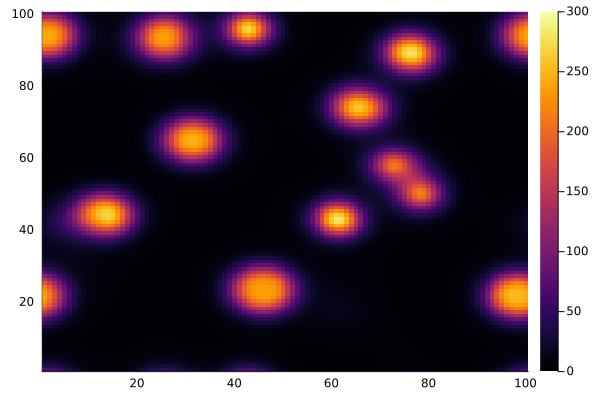

In [83]:
heatmap(sol[:,:,1,20], clim = (0,300))

┌ Info: Saved animation to /tmp/jl_EjupQZ8zej.gif
└ @ Plots /home/dinosaur/.julia/packages/Plots/HyyIK/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_EjupQZ8zej.gif")
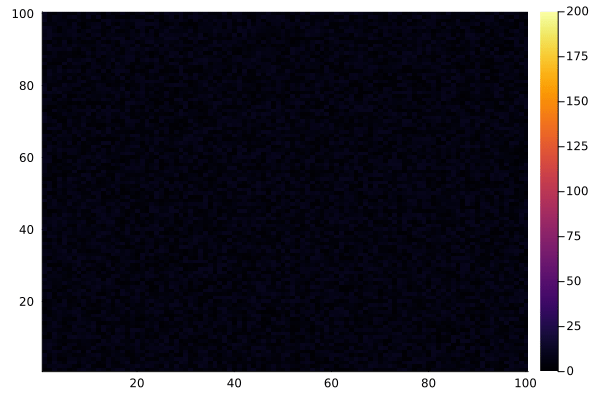

In [84]:
anim = @animate for i in 1:200
    Plots.heatmap(sol[:,:,1,i],clim=(0,200))
end
gif(anim, fps=60)